In [1]:
import geopandas as gpd

In [2]:
# get neighborhood boundaries from the LA Times
neighborhoods = gpd.read_file('http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-v5.geojson')

In [3]:
# trim the data to the bare minimum columns
neighborhoods = neighborhoods[['name','geometry']]
neighborhoods.head()

name                                           geometry
0            Acton  MULTIPOLYGON (((-118.20262 34.53899, -118.1894...
1  Adams-Normandie  MULTIPOLYGON (((-118.30901 34.03741, -118.3004...
2     Agoura Hills  MULTIPOLYGON (((-118.76193 34.16820, -118.7263...
3       Agua Dulce  MULTIPOLYGON (((-118.25468 34.55830, -118.2555...
4         Alhambra  MULTIPOLYGON (((-118.12175 34.10504, -118.1168...

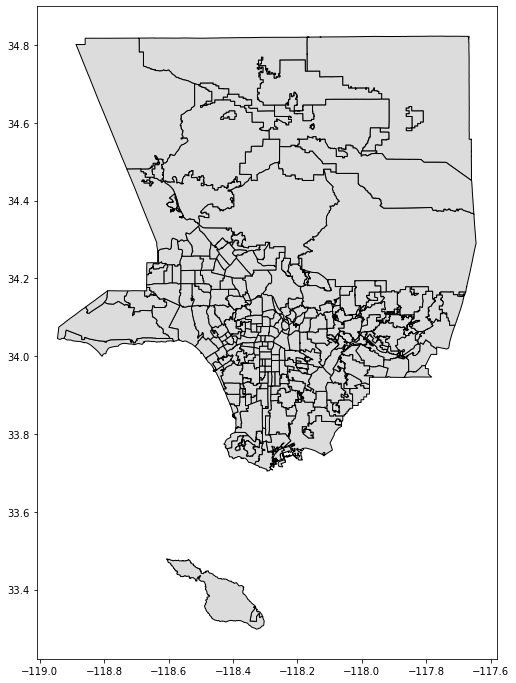

In [4]:
ax=neighborhoods.plot(figsize=(12,12),color='gainsboro', edgecolor='black')

In [5]:
import pandas as pd
import plotly.express as px
from sodapy import Socrata

In [6]:
# connect to the data portal
client = Socrata("data.lacity.org", None)

# We will look at current crime 
results = client.get("amvf-fr72", 
                     limit=1000,
                     where = "arst_date between '2020-01-01T00:00:00' and '2020-11-30T00:00:00'",
                     order='arst_date desc')

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

# print it with .sample, which gives you random rows
df.head()

rpt_id report_type                arst_date  time area    area_desc  \
0    6061589     BOOKING  2020-11-30T00:00:00.000  1618   08      West LA   
1    6061614     BOOKING  2020-11-30T00:00:00.000  1613   08      West LA   
2    6061344     BOOKING  2020-11-30T00:00:00.000  0300   12  77th Street   
3  201615223         RFC  2020-11-30T00:00:00.000  1150   16     Foothill   
4    6061724     BOOKING  2020-11-30T00:00:00.000  1920   05       Harbor   

     rd age sex_cd descent_cd  ...                                  location  \
0  0805  32      M          H  ...                                 SEPULVEDA   
1  0817  40      M          W  ...  10800    WEYBURN                      AV   
2  1233  21      M          B  ...           NORMANDIE                    AV   
3  1617  20      M          W  ...                                 FLORALITA   
4  0514  18      M          H  ...           25TH                         ST   

                             crsst      lat        lon  \
0  MORAGA                       DR  34.0776  -118.4693   
1                              NaN  34.0623  -118.4434   
2  68TH                         ST  33.9862  -118.3111   
3                         FOOTHILL  34.2597  -118.3179   
4  NORMANDIE                    AV  33.7897  -118.2787   

                                          location_1                 bkg_date  \
0  {'type': 'Point', 'coordinates': [-118.4693, 3...  2020-11-30T00:00:00.000   
1  {'type': 'Point', 'coordinates': [-118.4434, 3...  2020-11-30T00:00:00.000   
2  {'type': 'Point', 'coordinates': [-118.3111, 3...  2020-11-30T00:00:00.000   
3  {'type': 'Point', 'coordinates': [-118.3179, 3...                      NaN   
4  {'type': 'Point', 'coordinates': [-118.2787, 3...  2020-12-01T00:00:00.000   

  bkg_time       bgk_location bkg_loc_cd                   dispo_desc  
0     1843            77TH ST       4212                          NaN  
1     1957  VALLEY - JAIL DIV       4279       FELONY COMPLAINT FILED  
2     0515            77TH ST       4212                          NaN  
3      NaN                NaN        NaN  MISDEMEANOR COMPLAINT FILED  
4     0023             HARBOR       4205       FELONY COMPLAINT FILED  

[5 rows x 25 columns]

In [7]:
df.shape

(1000, 25)

In [8]:
# list columns
list(df)

['rpt_id',
 'report_type',
 'arst_date',
 'time',
 'area',
 'area_desc',
 'rd',
 'age',
 'sex_cd',
 'descent_cd',
 'chrg_grp_cd',
 'grp_description',
 'arst_typ_cd',
 'charge',
 'chrg_desc',
 'location',
 'crsst',
 'lat',
 'lon',
 'location_1',
 'bkg_date',
 'bkg_time',
 'bgk_location',
 'bkg_loc_cd',
 'dispo_desc']

In [9]:
# convert pandas dataframe to geodataframe
crime = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

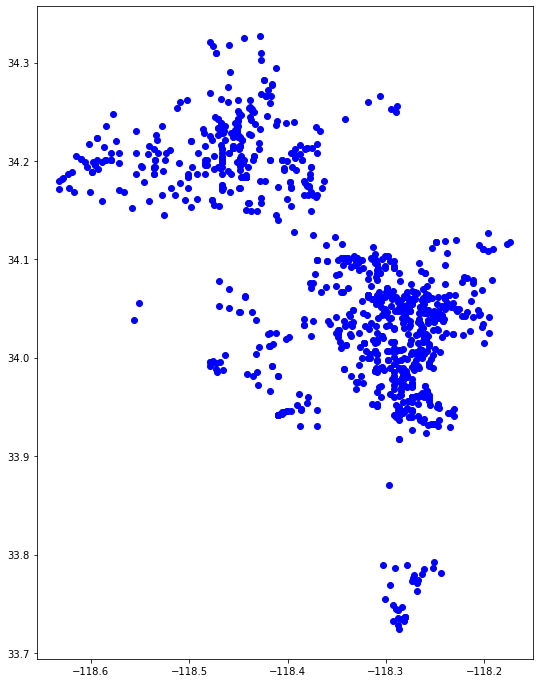

In [10]:
# mapping crime
crime.plot(figsize=(12,12),color='blue')

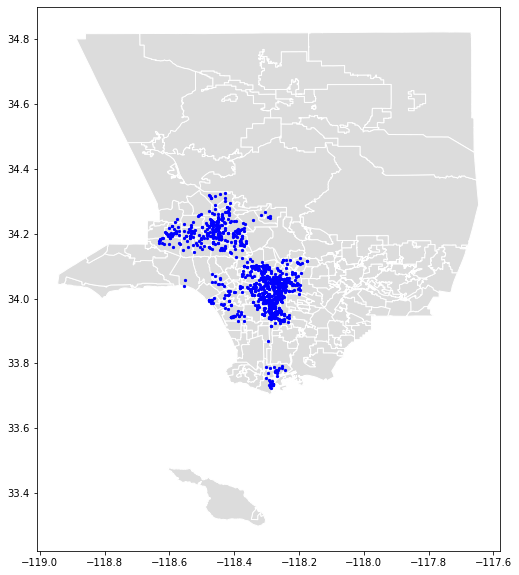

In [11]:
# creating a two layer map
# defining base map
base = neighborhoods.plot(figsize=(12,10),color='gainsboro', edgecolor='white')

# defining top layer
ax = crime.plot(ax=base, color='blue', markersize=5)

In [12]:
# get box coordinates for crime data
crime.geometry.total_bounds

array([-118.6321,   33.7242, -118.1738,   34.3268])

In [13]:
#creating coordinates for their own variable
minx, miny, maxx, maxy = crime.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-118.6321
-118.1738
33.7242
34.3268


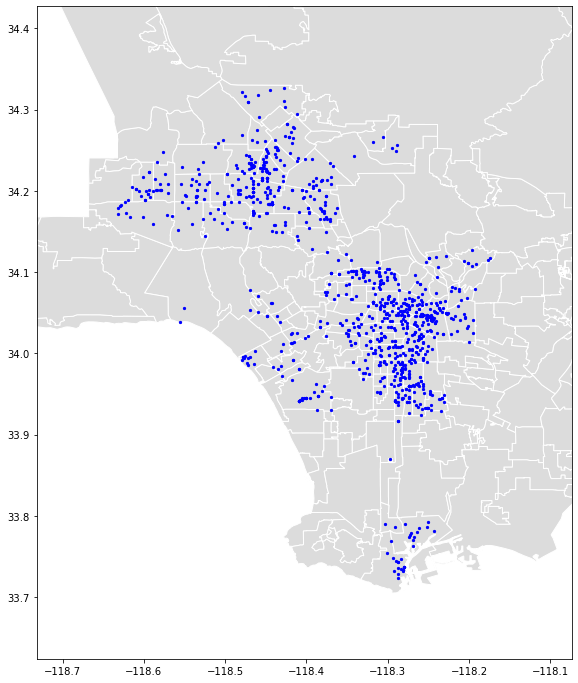

In [14]:
# limits for the x and y variables

base = neighborhoods.plot(figsize=(12,12),color='gainsboro', edgecolor='white')
ax = crime.plot(ax=base, marker='o', color='blue', markersize=5)
ax.set_xlim(minx - .1, maxx + .1)
ax.set_ylim(miny - .1, maxy + .1)
ax

In [15]:
# set the coordinate system to WGS84 for our crime data
crime.set_crs(epsg=4326, inplace=True)
crime.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
# checking neighborhood coordinate system
neighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
# Spatial join of the neighborhoods and crime
join = gpd.sjoin(neighborhoods,
                 crime,
                 how='right')

In [18]:
# joining crime to the neighborhood committed 
join.head()

index_left             name     rpt_id report_type  \
185         1.0  Adams-Normandie    6060884     BOOKING   
185       232.0  University Park    6060884     BOOKING   
828         1.0  Adams-Normandie    6058089     BOOKING   
318         1.0  Adams-Normandie  200321025         RFC   
174         1.0  Adams-Normandie    6061301     BOOKING   

                   arst_date  time area  area_desc    rd age  ...  \
185  2020-11-29T00:00:00.000  0310   03  Southwest  0325  27  ...   
185  2020-11-29T00:00:00.000  0310   03  Southwest  0325  27  ...   
828  2020-11-24T00:00:00.000  0020   03  Southwest  0325  23  ...   
318  2020-11-28T00:00:00.000  0830   03  Southwest  0326  26  ...   
174  2020-11-29T00:00:00.000  2115   03  Southwest  0317  37  ...   

                                  crsst      lat        lon  \
185  S  VERMONT                      AV  34.0287  -118.2915   
185  S  VERMONT                      AV  34.0287  -118.2915   
828                             CENTRAL  34.0307  -118.2923   
318     NORMANDIE                    AV  34.0327  -118.3002   
174                               ADAMS  34.0328  -118.2964   

                                            location_1  \
185  {'type': 'Point', 'coordinates': [-118.2915, 3...   
185  {'type': 'Point', 'coordinates': [-118.2915, 3...   
828  {'type': 'Point', 'coordinates': [-118.2923, 3...   
318  {'type': 'Point', 'coordinates': [-118.3002, 3...   
174  {'type': 'Point', 'coordinates': [-118.2964, 3...   

                    bkg_date bkg_time bgk_location bkg_loc_cd  \
185  2020-11-29T00:00:00.000     0507      77TH ST       4212   
185  2020-11-29T00:00:00.000     0507      77TH ST       4212   
828  2020-11-24T00:00:00.000     0333      77TH ST       4212   
318                      NaN      NaN          NaN        NaN   
174  2020-11-30T00:00:00.000     0233      77TH ST       4212   

                        dispo_desc                     geometry  
185  849(B)(1) PC/TECHNICAL ARREST  POINT (-118.29150 34.02870)  
185  849(B)(1) PC/TECHNICAL ARREST  POINT (-118.29150 34.02870)  
828         FELONY COMPLAINT FILED  POINT (-118.29230 34.03070)  
318    MISDEMEANOR COMPLAINT FILED  POINT (-118.30020 34.03270)  
174  849(B)(1) PC/TECHNICAL ARREST  POINT (-118.29640 34.03280)  

[5 rows x 28 columns]

In [19]:
# counting crime by neighborhood
crime_by_neighborhoods = join.name.value_counts().rename_axis('name').reset_index(name='crime_count')

In [20]:
crime_by_neighborhoods.head()

name  crime_count
0       Van Nuys           62
1       Downtown           60
2  Panorama City           40
3       Westlake           34
4      Hollywood           32

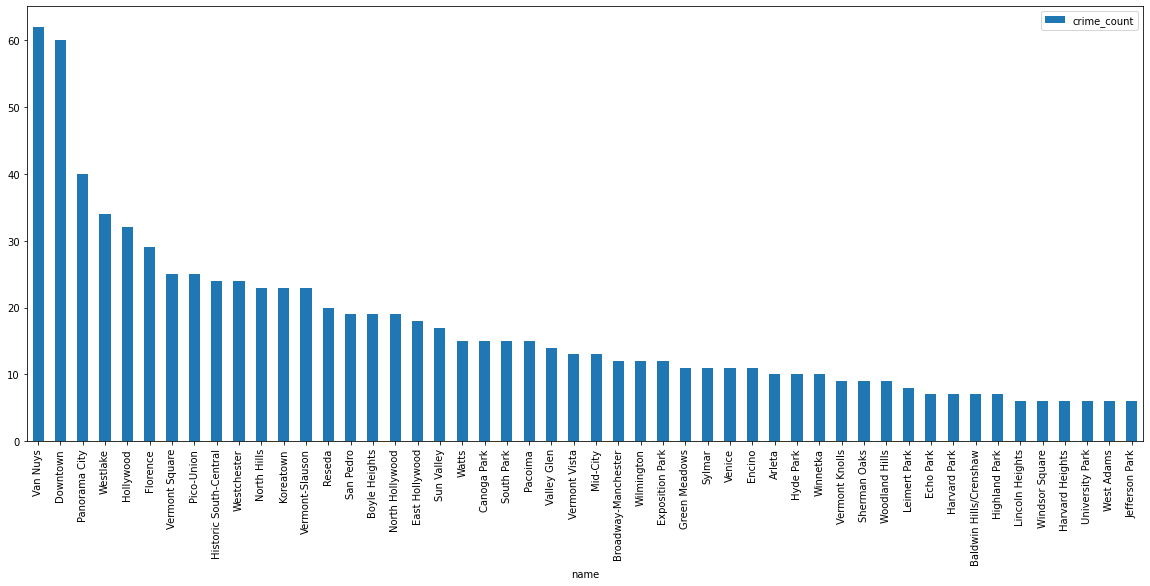

In [21]:
# making a bar chart of crime rates by neighborhood
crime_by_neighborhoods[:50].plot.bar(figsize=(20,8),x='name',y='crime_count')

In [22]:
# join the summary table back to the neighborhood geodatabase
neighborhoods=neighborhoods.merge(crime_by_neighborhoods,on='name')

In [23]:
# our neighborhood table with count column
neighborhoods.head()

name                                           geometry  \
0         Adams-Normandie  MULTIPOLYGON (((-118.30901 34.03741, -118.3004...   
1                  Arleta  MULTIPOLYGON (((-118.42202 34.22410, -118.4228...   
2       Arlington Heights  MULTIPOLYGON (((-118.31591 34.05261, -118.3134...   
3         Atwater Village  MULTIPOLYGON (((-118.27832 34.15301, -118.2770...   
4  Baldwin Hills/Crenshaw  MULTIPOLYGON (((-118.35626 34.02484, -118.3550...   

   crime_count  
0            5  
1           10  
2            2  
3            1  
4            7

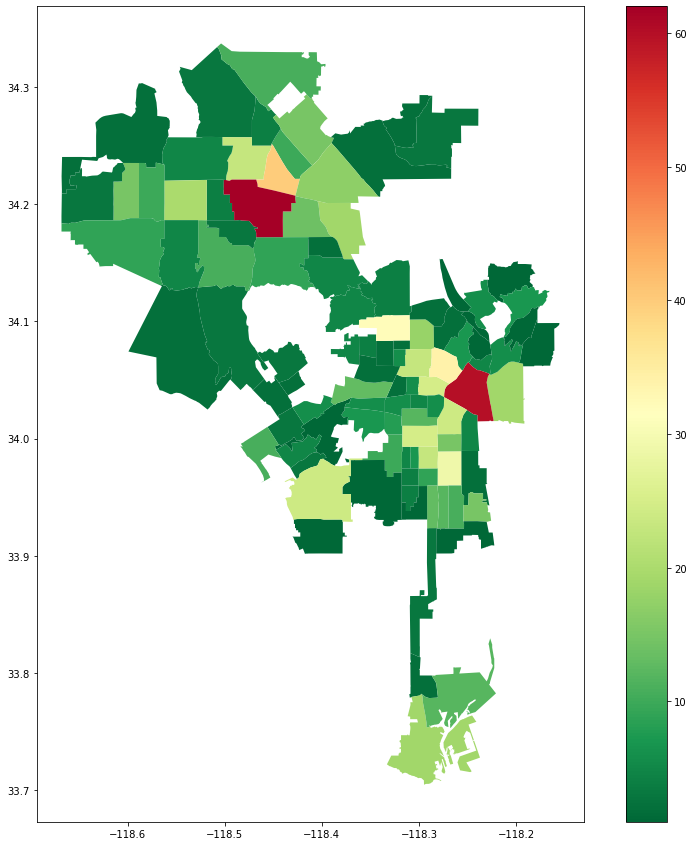

In [24]:
# plotting data
neighborhoods.plot(figsize=(15,15),column='crime_count',legend=True,cmap='RdYlGn_r')

In [25]:
# for basemaps
import contextily as ctx

In [26]:
# reproject to web mercator
neighborhoods = neighborhoods.to_crs(epsg=3857)

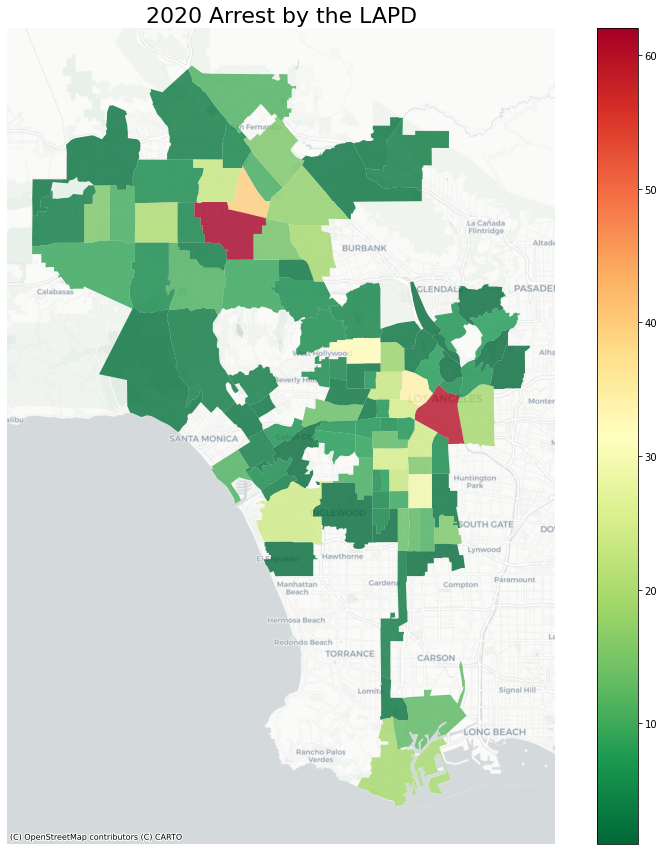

In [27]:
ax = neighborhoods.plot(figsize=(15,15),
                        column='crime_count',
                        legend=True,
                        alpha=0.8,
                        cmap='RdYlGn_r')

ax.axis('off')
ax.set_title('2020 Arrest by the LAPD',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [28]:
import plotly.express as px

In [29]:
neighborhoods = neighborhoods.to_crs(epsg=4326)

In [30]:
neighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
minx, miny, maxx, maxy = neighborhoods.geometry.total_bounds

In [32]:
center_lat=(maxy-miny)/2+miny
center_lat

34.020922350091055

In [33]:
center_lon=(maxx-minx)/2+minx
center_lon

-118.41173300000008

In [34]:
fig = px.choropleth_mapbox(neighborhoods, 
                           geojson=neighborhoods.geometry, 
                           locations=neighborhoods.index, 
                           color='crime_count',
                           color_continuous_scale="rdylgn_r",
                           mapbox_style="carto-positron",
                           zoom=9, 
                           center = {"lat": center_lat, "lon": center_lon},
                           hover_name=neighborhoods.name,
                           opacity=0.5
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [35]:
fig.write_html("lacrime2020.html")